! pip install -U --user hmmlearn

# Example

In [101]:
from __future__ import print_function

import datetime


import numpy as np
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
try:
    from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
    # For Matplotlib prior to 1.5.
    from matplotlib.finance import (
        quotes_historical_yahoo as quotes_historical_yahoo_ochl
    )

from hmmlearn.hmm import GaussianHMM

print(__doc__)

Automatically created module for IPython interactive environment


In [139]:
def HMM(stock, start, end, isPrint = False):
    quotes = quotes_historical_yahoo_ochl( stock, start, end)

    # Unpack quotes
    dates = np.array([q[0] for q in quotes], dtype=int)
    close_v = np.array([q[2] for q in quotes])
    volume = np.array([q[5] for q in quotes])[1:]
    open_v = np.array([q[1] for q in quotes])
    high_v = np.array([q[3] for q in quotes])
    low_v = np.array([q[4] for q in quotes])

    diff = np.diff(close_v)
    dates = dates[1:]
    gap = close_v[1:] - open_v[0:(len(open_v)-1)]
    close_v = close_v[1:]
    # open_v =open_v[1:]
    diff_op = np.diff(open_v)
    # high_v = high_v[1:]
    # low_v = low_v[1:]

    # quotes
    X = np.column_stack([diff, volume]) 
#     X = np.column_stack([close_v, open_v, high_v,low_v]) 
    # Make an HMM instance and execute fit
    model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
    
    # Predict the optimal sequence of internal hidden state
    hidden_states = model.predict(X)
    
#     isPrint = False
    if isPrint:
        print("Transition matrix")
        print(model.transmat_)
        print()

        print("Means and vars of each hidden state")
        for i in range(model.n_components):
            print("{0}th hidden state".format(i))
            print("mean = ", model.means_[i])
            print("var = ", np.diag(model.covars_[i]))
            print()
            
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            # Use fancy indexing to plot data in each state.
            mask = hidden_states == i
            ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
            ax.set_title("{0}th hidden state".format(i))

            # Format the ticks.
            ax.xaxis.set_major_locator(YearLocator())
            ax.xaxis.set_minor_locator(MonthLocator())
            ax.grid(True)

        plt.show()
    
    
    Zn_post = model.predict_proba(X)[-1]
    Zn1Zn = (model.transmat_.T * Zn_post).T
    Zn1_post = np.sum(Zn1Zn, axis = 0)
    
    x = np.linspace(-100,100,1000000)
    if isPrint:
        plt.plot(x,mix_normal(model, x, Zn1_post))
    predict = x[np.argmax(mix_normal(model, x, Zn1_post))]
    
    return predict+close_v[-1]

import scipy.stats as sp
def mix_normal(model, x,Zn1_post):
    r = 0
    for i in range(4):
        r += sp.norm.pdf(x,model.means_[i][0],model.covars_[i][0,0])*Zn1_post[i]
    return r


In [140]:
def MSE(df, df_true):
    output = []
    for i in range(df.shape[1]):
        output.append(sum((df.ix[:,i]- df_true.ix[:,i])**2)/df.shape[1])
    return output

Transition matrix
[[  1.44968350e-09   1.64314319e-02   9.08628560e-01   7.49400061e-02]
 [  2.43200188e-01   7.54995803e-01   1.80400942e-03   2.47707221e-84]
 [  4.24773249e-01   4.73953634e-01   1.01273117e-01   1.86684805e-28]
 [  1.66634593e-01   3.09219360e-86   9.08253705e-32   8.33365407e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [ -5.95807543e+00   2.90923578e+06]
var =  [  1.24589414e+02   2.40490139e+11]

1th hidden state
mean =  [  7.42297517e-01   1.73537455e+06]
var =  [  3.97065281e+01   5.93782004e+10]

2th hidden state
mean =  [  9.37020273e+00   2.25611319e+06]
var =  [  1.15108379e+02   6.28415161e+10]

3th hidden state
mean =  [ -1.00311585e+01   5.36291059e+06]
var =  [  3.35962786e+02   5.04378695e+11]



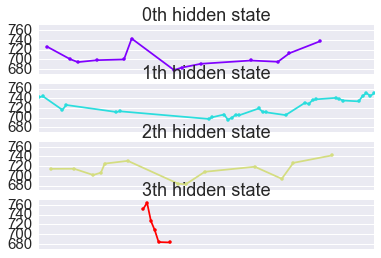

750.58487367490068

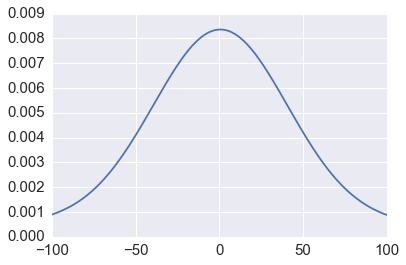

In [173]:
HMM('GOOG', datetime.datetime(2016,1,1), datetime.datetime(2016,4,1),True)

In [121]:
import pandas as pd
from pandas import Series, DataFrame
from datetime import timedelta

In [176]:
company = ["AAPL","FB","LNKD","AMZN","GOOG","MSFT","BABA"]
# preDate =  np.asarray(pd.date_range('4/1/2016', periods=30))
# pd.Timestamp(preDate[1]).to_pydatetime().date()
numdays = 20
# base = datetime.datetime.today().date() -timedelta(1)
base = datetime.datetime(2016,4,20)
preDate = [base - datetime.timedelta(days=x) for x in range(0, numdays)]

In [177]:
# quotes_historical_yahoo_ochl('LNKD', datetime.datetime(2016,3,27), datetime.datetime(2016,3,27))

In [178]:
# true data
df_true =DataFrame(index = preDate, columns = company)
for date in preDate:
    for comp in company:
#         print(date)
#         print(comp)
        true = quotes_historical_yahoo_ochl(comp, date, date)
        if true is None:
            df_true[comp][date] = None
        else:
            df_true[comp][date] = true[0][1]

df_true.head()

,AAPL,FB,LNKD,AMZN,GOOG,MSFT,BABA
2016-04-20,106.64,112.43,115.75,630,758,56.29,79
2016-04-19,107.88,111.1,118.22,637.14,769.51,56.63,79.2
2016-04-18,108.89,109.74,115.76,625.35,760.46,55.49,78.52
2016-04-17,None,None,None,None,None,None,None
2016-04-16,None,None,None,None,None,None,None


In [179]:
trueDate = np.array([preDate[i] for i,check in enumerate(df_true.ix[:,1]) if not check is None])
df_true= df_true.ix[trueDate,:]
df = DataFrame(index = trueDate, columns = company)

In [185]:
#test

dff = DataFrame(index = trueDate, columns = ['GOOG'])
for date in trueDate:
     dff['GOOG'][date] = HMM('GOOG', date-timedelta(71), date-timedelta(1))
dff.head(10)

,GOOG
2016-04-20,759.74
2016-04-19,766.836
2016-04-18,758.763
2016-04-15,752.785
2016-04-14,752.107
2016-04-13,741.898
2016-04-12,735.796
2016-04-11,739.065
2016-04-08,740.918
2016-04-07,746.657


In [186]:
dff

,GOOG
2016-04-20,759.74
2016-04-19,766.836
2016-04-18,758.763
2016-04-15,752.785
2016-04-14,752.107
2016-04-13,741.898
2016-04-12,735.796
2016-04-11,739.065
2016-04-08,740.918
2016-04-07,746.657


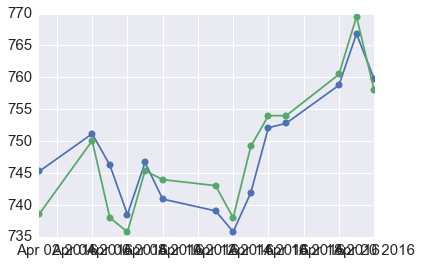

In [187]:
fig, ax = plt.subplots()
ax.plot_date(trueDate, dff['GOOG'][trueDate], marker='o', linestyle='-')
ax.plot_date(trueDate, df_true['GOOG'][trueDate], marker='o', linestyle='-')


In [182]:
# for date in trueDate:
#     for comp in company:
#         df[comp][date] = HMM(comp, date-timedelta(71), date-timedelta(1))
# df.head(10)

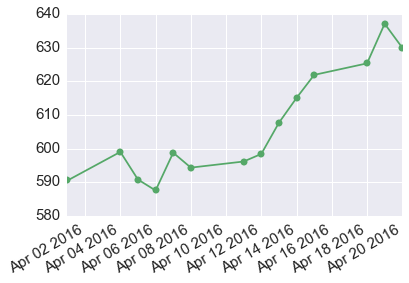

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot_date(trueDate, df['AMZN'][trueDate], marker='o', linestyle='-')
ax.plot_date(trueDate, df_true['AMZN'][trueDate], marker='o', linestyle='-')

fig.autofmt_xdate()
plt.show()

# fig, ax = plt.subplots()
# ax.plot_date(trueDate, df['GOOG'], marker='o', linestyle='-')
# ax.plot_date(preDate, df_true['GOOG'], marker='o', linestyle='-')


# fig.autofmt_xdate()
# plt.show()

In [194]:
DataFrame(df_true['GOOG'])

,GOOG
2016-04-20,758
2016-04-19,769.51
2016-04-18,760.46
2016-04-15,753.98
2016-04-14,754.01
2016-04-13,749.16
2016-04-12,738
2016-04-11,743.02
2016-04-08,743.97
2016-04-07,745.37


In [195]:
MSE(dff,DataFrame(df_true['GOOG']))

[223.72093542304941]

In [196]:
dff-DataFrame(df_true['GOOG'])

,GOOG
2016-04-20,1.7401
2016-04-19,-2.67432
2016-04-18,-1.69672
2016-04-15,-1.19487
2016-04-14,-1.90314
2016-04-13,-7.26245
2016-04-12,-2.20392
2016-04-11,-3.9553
2016-04-08,-3.05244
2016-04-07,1.28651


$P(Z_n | x_1 \dots, x_n) $

In [296]:
Zn_post = model.predict_proba(X)[-1]

$P(Z_{n+1}, Z_{n} | X_1, \dots, X_n) = P(Z_{n+1} | Z_n) * P(Z_n | x_1 \dots, x_n)$

In [297]:
Zn1Zn = (model.transmat_.T * Zn_post).T

$P(Z_{n+1} | X_1, \dots, X_n) = \sum_{i=1}^{4} P(Z_{n+1}, Z_{n} =i | X_1, \dots, X_n) $

In [298]:
Zn1_post = np.sum(Zn1Zn, axis = 0)

In [299]:
Zn1_post 

array([  5.96671768e-05,   3.27469809e-01,   4.40764272e-02,
         6.28394096e-01])

In [30]:
test = quotes_historical_yahoo_ochl(
    "AAPL", datetime.date(2016, 4, 1), datetime.date(2016, 4, 2))

In [31]:
test

[(736055.0, 108.779999, 109.989998, 110.0, 108.199997, 25626200.0)]